In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

import numpy as np
import pandas as pd

# Import and transform data

In [2]:
# Step 1: Load the train and test CSV files
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

# Step 2: Prepare the training data
# Separate the labels and pixel data for the training set
X_train = train_data.drop(columns=['label']).values  # Pixel values (features)
y_train = train_data['label'].values  # Labels (target)

# Normalize the pixel values (0-255 -> 0-1)
X_train = X_train / 255.0

# Reshape X_train to (-1, 1, 28, 28) to match the format for CNN input (batch_size, channels, height, width)
X_train = X_train.reshape(-1, 1, 28, 28)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Step 3: Create the DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

# Step 4: Prepare the test data
# Separate the labels and pixel data for the test set
X_test = test_data.drop(columns=['label']).values  # Pixel values (features)
y_test = test_data['label'].values  # Labels (target)

# Normalize the pixel values (0-255 -> 0-1)
X_test = X_test / 255.0

# Reshape X_test to (-1, 1, 28, 28) to match the format for CNN input
X_test = X_test.reshape(-1, 1, 28, 28)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create the DataLoader for the test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Model

In [3]:
# Step 5: Define the corrected CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted fully connected layer
        self.fc2 = nn.Linear(128, 25)  # Output layer (25 classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First conv -> relu -> maxpool
        x = self.pool(F.relu(self.conv2(x)))  # Second conv -> relu -> maxpool
        x = x.view(-1, 64 * 7 * 7)  # Correctly flatten the feature maps
        x = F.relu(self.fc1(x))  # Fully connected layer with ReLU activation
        x = self.fc2(x)  # Output layer
        return x

# Step 6: Initialize the model, criterion, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and Test

In [4]:
import time
start_time = time.time()

# Create variables to track progress
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Training loop
    model.train()
    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
        batch_idx += 1  # Start batches at 1

        # Forward pass
        y_pred = model(X_train_batch)
        loss = criterion(y_pred, y_train_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train_batch).sum().item()
        trn_corr += batch_corr

        # Print loss every 600 batches
        if batch_idx % 600 == 0:
            print(f'Epoch: {epoch+1} Batch: {batch_idx} Loss: {loss.item()}')

    # Record training loss and accuracy
    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    # Testing loop
    model.eval()
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            y_val = model(X_test_batch)
            loss = criterion(y_val, y_test_batch)

            # Calculate test accuracy
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test_batch).sum().item()

    # Record test loss and accuracy
    test_losses.append(loss.item())
    test_correct.append(tst_corr)

    # Print epoch summary
    print(f'Epoch {epoch+1} completed. Training accuracy: {trn_corr/len(train_dataset)*100:.2f}% Test accuracy: {tst_corr/len(test_dataset)*100:.2f}%')

total_time = time.time() - start_time
print(f'Training Took: {total_time/60:.2f} minutes!')


Epoch: 1 Batch: 600 Loss: 0.4968568682670593
Epoch 1 completed. Training accuracy: 69.60% Test accuracy: 80.17%
Epoch: 2 Batch: 600 Loss: 0.0705220103263855
Epoch 2 completed. Training accuracy: 97.45% Test accuracy: 88.71%
Epoch: 3 Batch: 600 Loss: 0.005322026088833809
Epoch 3 completed. Training accuracy: 99.45% Test accuracy: 88.79%
Epoch: 4 Batch: 600 Loss: 0.0016625832067802548
Epoch 4 completed. Training accuracy: 99.69% Test accuracy: 89.97%
Epoch: 5 Batch: 600 Loss: 0.0009814526420086622
Epoch 5 completed. Training accuracy: 99.89% Test accuracy: 90.23%
Training Took: 0.83 minutes!


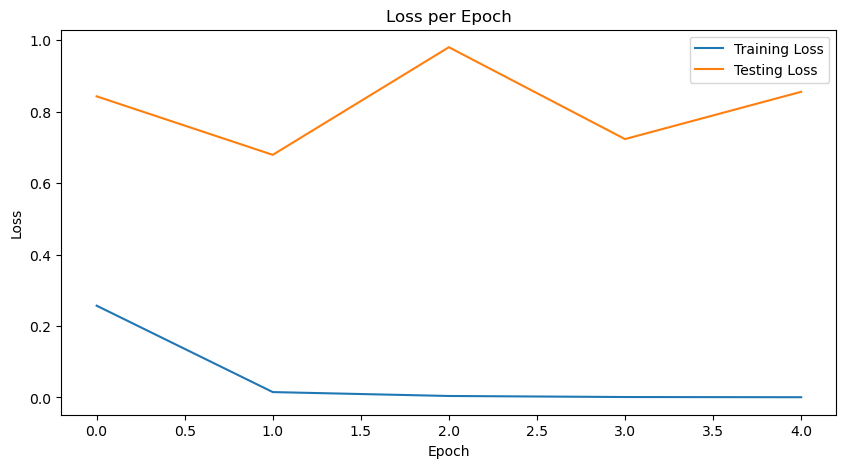

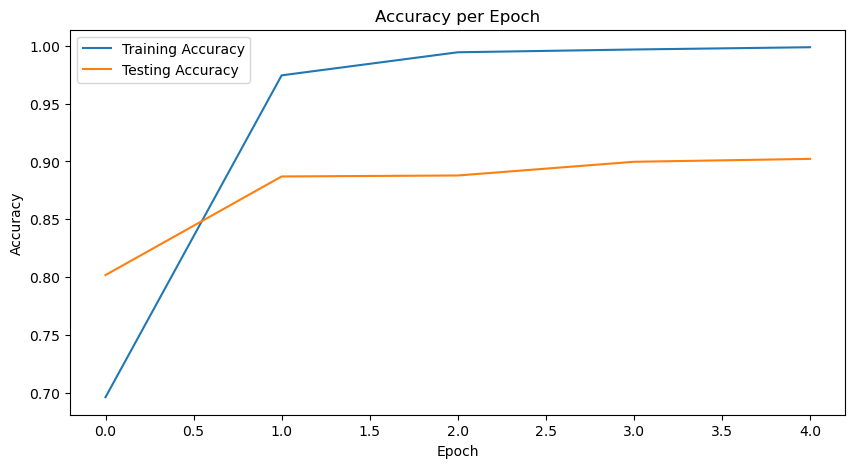

In [5]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot accuracies
plt.figure(figsize=(10,5))
plt.plot([t/len(train_dataset) for t in train_correct], label='Training Accuracy')
plt.plot([t/len(test_dataset) for t in test_correct], label='Testing Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


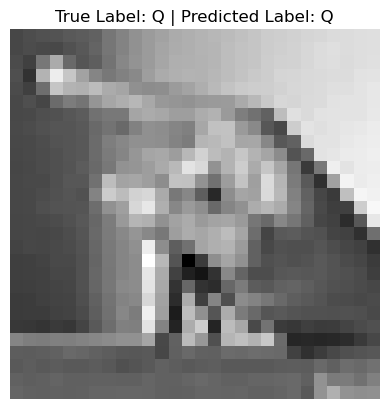

In [6]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import string

# Set the random seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create a mapping from labels to letters
letters = [letter for letter in string.ascii_uppercase if letter not in ('J', 'Z')]
label_to_letter = {i: letter for i, letter in enumerate(letters)}

# Randomly select an image from the test dataset
total_test_samples = len(test_dataset)
random_idx = random.randint(0, total_test_samples - 1)
image_tensor, true_label = test_dataset[random_idx]
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

# Perform inference
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_label = torch.max(output, 1)
    predicted_label = predicted_label.item()
    true_label = true_label.item()

# Map labels to letters
true_letter = label_to_letter[true_label]
predicted_letter = label_to_letter[predicted_label]

# Display the image and prediction
image_np = image_tensor.squeeze().numpy()

plt.imshow(image_np, cmap='gray')
plt.title(f'True Label: {true_letter} | Predicted Label: {predicted_letter}')
plt.axis('off')
plt.show()


In [7]:
torch.save(model.state_dict(), 'Handsign_classification.pt')

In [9]:
new_model = CNN()
new_model.load_state_dict(torch.load('Handsign_classification.pt'))

new_model.eval()

C:\Users\Kanta\AppData\Local\Temp\ipykernel_30360\79111949.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('Handsign_classification.

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=25, bias=True)
)